In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

H, W = 400, 700

In [2]:
# TV 화면 속 총 점만 잘라내주는 작업

def process_img(index):
    src = './img/' + str(index)+'.jpg'
    try:
        img = cv2.imread(src)
        height, weight, channel = img.shape
        img = cv2.resize(img, (W,H))
        plt.figure(figsize = (12,10))
        plt.imshow(img, cmap = 'gray')

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_blurred = cv2.GaussianBlur(img_gray, ksize = (5,5), sigmaX = 0)
        img_thresh = cv2.adaptiveThreshold(img_blurred, maxValue = 255.0,
                                          adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          thresholdType = cv2.THRESH_BINARY_INV,
                                          blockSize = 19, C = 9)
        plt.figure(figsize = (12,10))
        plt.imshow(img_gray, cmap='gray')
        plt.figure(figsize = (12,10))
        plt.imshow(img_blurred, cmap = 'gray')
        plt.figure(figsize = (12,10))
        plt.imshow(img_thresh, cmap = 'gray')

        contours, _ = cv2.findContours(
            img_thresh,
            mode = cv2.RETR_LIST,
            method = cv2.CHAIN_APPROX_SIMPLE
        )

        temp_result = np.zeros((H,W, channel), dtype = np.uint8)

        cv2.drawContours(temp_result, contours = contours, 
                         contourIdx = -1, color = (255,255,255))
        plt.figure(figsize = (12,10))
        plt.imshow(temp_result)

        contours_dict = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(temp_result, pt1 = (x,y), pt2 = (x+w, y+h),
                         color = (255,255,255), thickness = 1)
            contours_dict.append({
                'contour' : contour,
                'x' : x,
                'y' : y,
                'w' : w,
                'h' : h,
                'cx' : x + (w/2),
                'cy' : y + (h/2)
            })

        plt.figure(figsize=(12,10))
        plt.imshow(temp_result, cmap = 'gray')

        MIN_AREA = 2000
        MIN_WIDTH, MIN_HEIGHT = 1, 1
        MIN_RATIO, MAX_RATIO = 1.0, 1.5

        possible_contours = []

        cnt = 0

        for d in contours_dict:
            area = d['w'] * d['h']
            ratio = d['w'] / d['h']

            if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
                d['idx'] = cnt
                cnt += 1
                possible_contours.append(d)

        temp_result = np.zeros((H, W, channel), dtype = np.uint8)

        for d in possible_contours:
            cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2 = (d['x']+d['w'], d['y']+d['h']),
                         color = (255,255,255), thickness = 2)

        plt.imshow(temp_result, cmap = 'gray')

        plate_width = possible_contours[0]['w']
        plate_height = possible_contours[0]['h']
        plate_cx = possible_contours[0]['cx']
        plate_cy = possible_contours[0]['cy']

        for d in possible_contours:
            plate_width = max(plate_width, d['w'])
            plate_height = max(plate_height, d['h'])
            plate_cx = max(plate_cx, d['cx'])
            plate_cy = max(plate_cy, d['cy'])

        img_cropped = cv2.getRectSubPix(
            img,
            patchSize = (plate_width+30, int(plate_height/2)+14),
            center = (plate_cx, plate_cy+10)
        )

        plt.imshow(img_cropped, cmap = 'gray')

        plate_img = []

        for d in possible_contours:
            pw = d['w']
            ph = d['h']
            pcx = d['cx']
            pcy = d['cy']

            img_cropped = cv2.getRectSubPix(
                img,
                patchSize = (pw+20, int(ph/2)+20),
                center = (pcx+10, pcy+20)
            )

            plate_img.insert(0, img_cropped)

        for i in range(len(plate_img)):
            plt.subplot(1, len(plate_img), i+1)
            plt.imshow(plate_img[i], cmap='gray')
            plt.axis('off')

        txt = []
        for i in range(len(plate_img)):
            txt.append(pytesseract.image_to_string(plate_img[i], config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'))
            plt.subplot(1, len(plate_img), i+1)
            plt.imshow(plate_img[i], cmap='gray')
            plt.axis('off')
            fname = './cropped/file_' + str(index) + '_cropped_' + str(i) + '.jpg'
            cv2.imwrite(fname, plate_img[i])

        print('Done')
            
        return True
    except:
        return False

Done


True

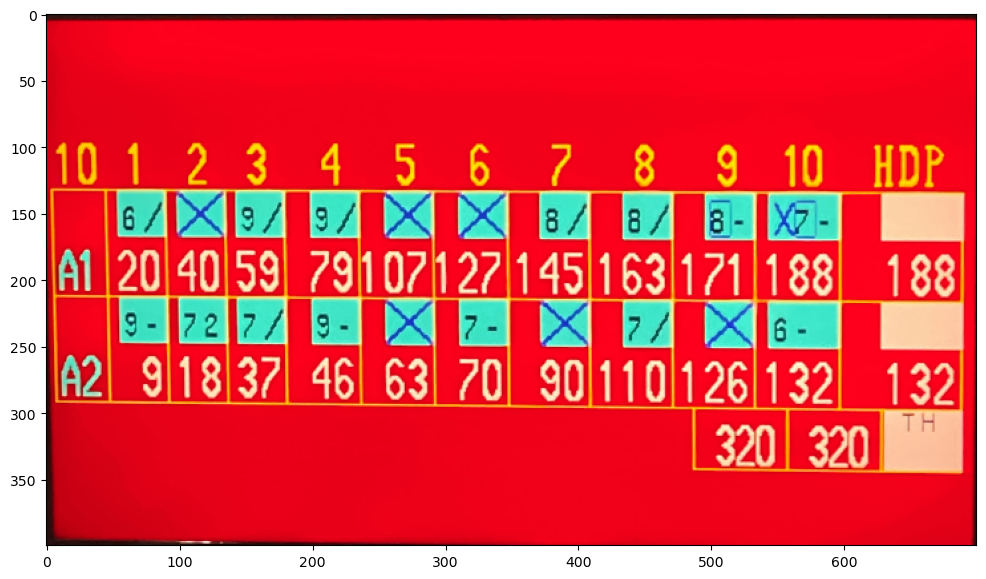

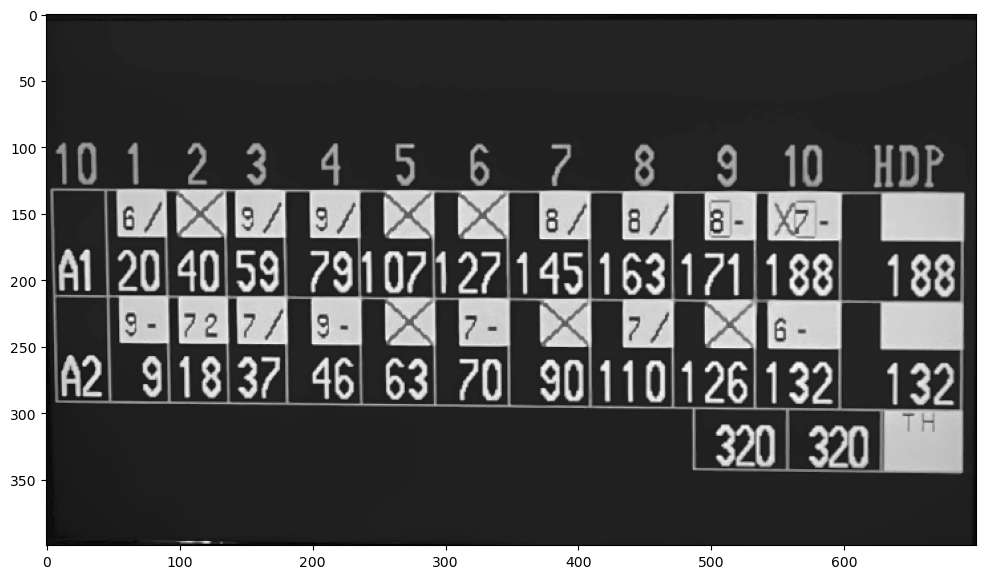

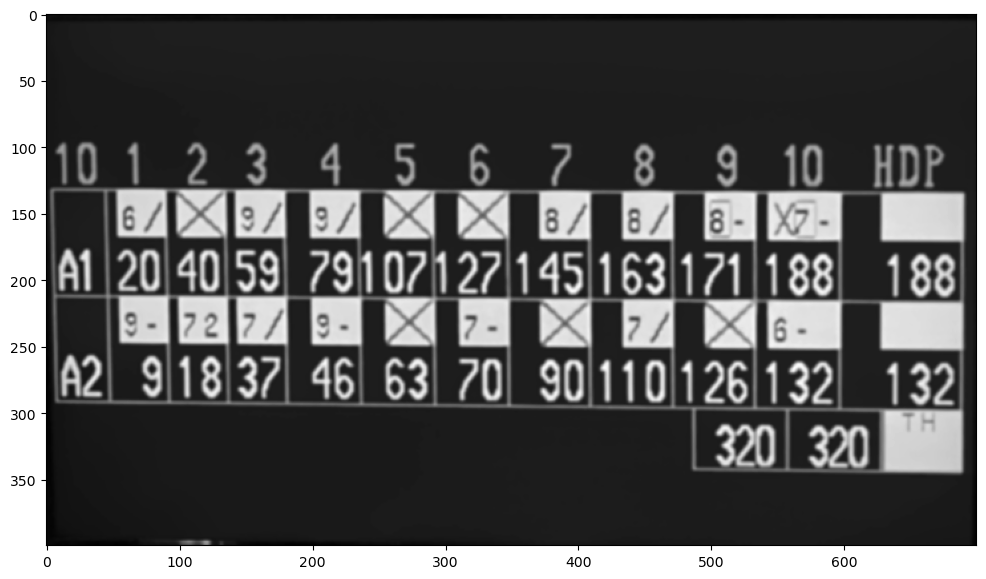

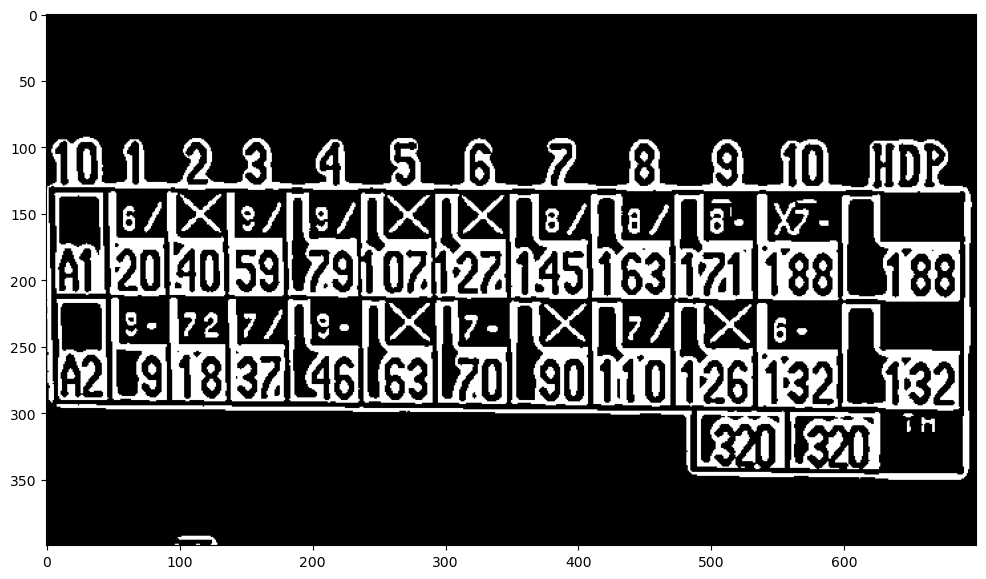

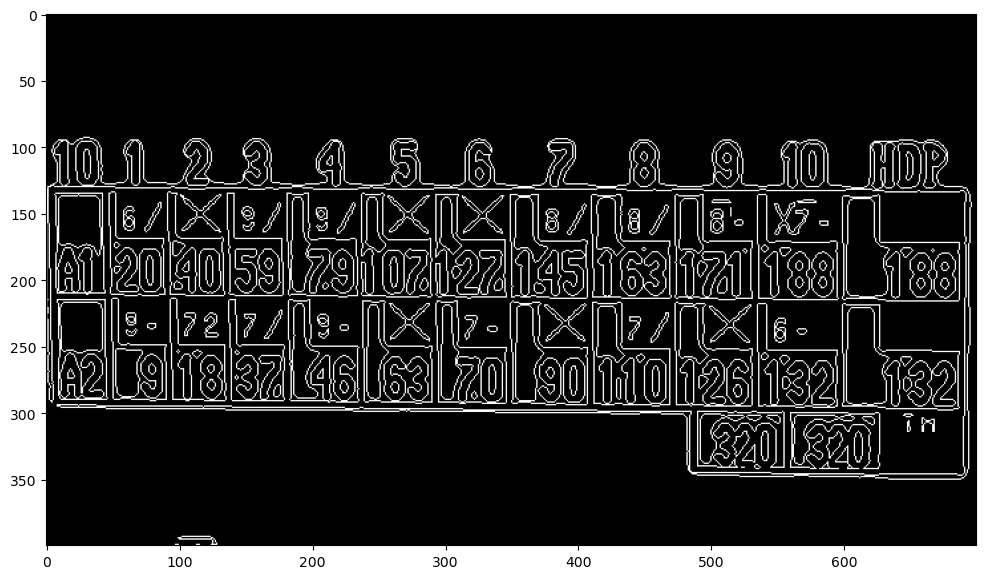

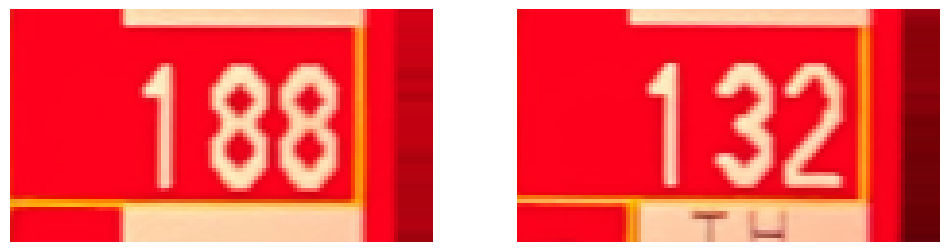

In [3]:
process_img(11)